In [2]:
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
import nltk
# nltk.download('stopwords')

current_dir = os.getcwd()
auto_dir = 'News/industrial_automation'
content = 'content'
date = 'date'
docs_dir_auto = os.path.join(current_dir, auto_dir, content)
dates_dir_auto = os.path.join(current_dir, auto_dir, date)

all_text = []
all_cls = []  # List to store class labels
all_dates = []

# Initialize the NLTK stopwords
# stop_words = set(nltk.corpus.stopwords.words('english'))

# def preprocess_text(text):
#     # Convert text to lowercase
#     text = text.lower()
#     # Split the text into words
#     words = text.split()
#     # Remove stopwords
#     words = [word for word in words if word not in stop_words]
#     # Rejoin the words into a single string
#     return " ".join(words)

for i in range(1, 1680):  # Adjust the range if needed
    file_path = os.path.join(docs_dir_auto, f"{i}.txt")
    date_file_path = os.path.join(dates_dir_auto, f"{i}.txt")

    with open(file_path, "r", encoding="utf-8") as file:
        docs_text = file.read()

    with open(date_file_path, "r", encoding="utf-8") as date_file:
        date_str = date_file.read()

    # Convert date_str to datetime
    date = pd.to_datetime(date_str, errors='coerce')

    if date is not None and date.year >= 2022:
        # docs_text = preprocess_text(docs_text)
        all_dates.append(date)
        all_text.append(docs_text)
        all_cls.append("AI")

TF_vectorizer = CountVectorizer(min_df=1, stop_words='english')
TF_vectors = TF_vectorizer.fit_transform(all_text)

# Use Latent Dirichlet Allocation (LDA) instead of TruncatedSVD
n_topics = 10  # Choose the number of topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
LDA_vectors = lda_model.fit_transform(TF_vectors)

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    for topic_index, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_index)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda_model, TF_vectorizer, 10)


Topic #0:
automation abb energy manufacturing production process systems solutions company technology

Topic #1:
manufacturing automation company new said industry canada technology solutions companies

Topic #2:
motion control automation robot robots new systems applications solutions product

Topic #3:
market manufacturing sales new firms demand output month inflation research

Topic #4:
data control devices power new equipment ethernet industrial network time

Topic #5:
robot robots robotics technology ai time manufacturing robotic vision systems

Topic #6:
new machine systems series industrial safety cobot isa automation cobots

Topic #7:
data digital industrial software security ai automation systems technology siemens

Topic #8:
sensor sensors light new applications used industrial use gripper designed

Topic #9:
motors power circuit amr new otto amrs industrial used electrical


In [3]:
# Create DataFrame for analysis
df = pd.DataFrame({'Season': [date.quarter for date in all_dates],
                   'Year': [date.year for date in all_dates],
                   'Topic': LDA_vectors.argmax(axis=1)})

# Group by season, year, and topic, count the number of documents
result = df.groupby(['Season', 'Year', 'Topic']).size().reset_index(name='Count')

# Pivot the result DataFrame
result_pivoted = result.pivot_table(index=['Year', 'Season'], columns='Topic', values='Count', fill_value=0).astype(int)

# Print the pivoted result
print(result_pivoted)

Topic         0   1   2   3   4   5   6   7   8   9
Year Season                                        
2022 1       11  63  23   2  12  21   3  26   5   8
     2       12  48  23   6  12  18  10  16   8   4
     3       10  48  18   5  16  26  13  18  22   8
     4        3  50  13   7  15  30   7  23   8   9
2023 1       17  68  11   3  24  21   9  17   7   8
     2        9  62   8   6  23  31  12  19  17   7
     3       12  56  16   4  37  23   6  15  22  16
     4       39  95  17  15  46  29  26  92  41  13


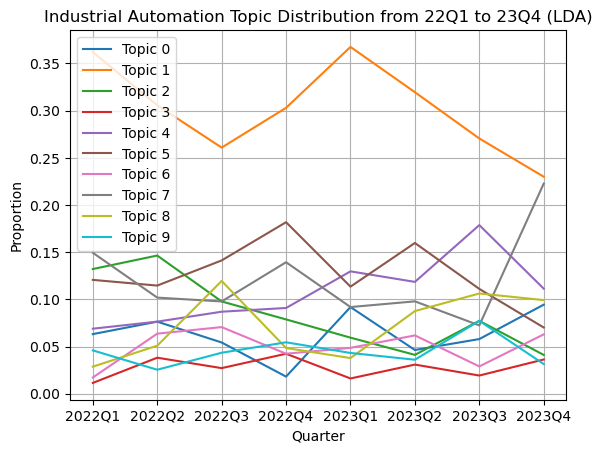

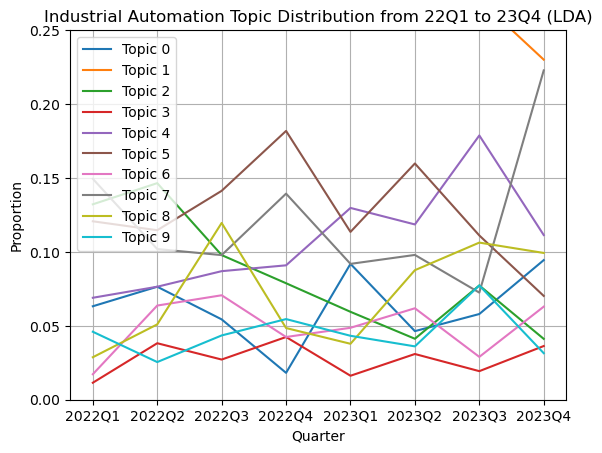

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for (year, season) in result_pivoted.index:
    result_pivoted.loc[(year, season)] /= np.sum(result_pivoted.loc[(year, season)])

yr_season_ticks = [f"{year}Q{season}" for (year, season) in result_pivoted.index]
for topic in result_pivoted:
    plt.plot(yr_season_ticks, result_pivoted[topic].values, label=f"Topic {topic}")
plt.title("Industrial Automation Topic Distribution from 22Q1 to 23Q4 (LDA)")
plt.xlabel("Quarter")
plt.ylabel("Proportion")
plt.legend()
plt.grid()
plt.show()

yr_season_ticks = [f"{year}Q{season}" for (year, season) in result_pivoted.index]
for topic in result_pivoted:
    plt.plot(yr_season_ticks, result_pivoted[topic].values, label=f"Topic {topic}")
plt.title("Industrial Automation Topic Distribution from 22Q1 to 23Q4 (LDA)")
plt.xlabel("Quarter")
plt.ylabel("Proportion")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([0, 0.25])
plt.show()

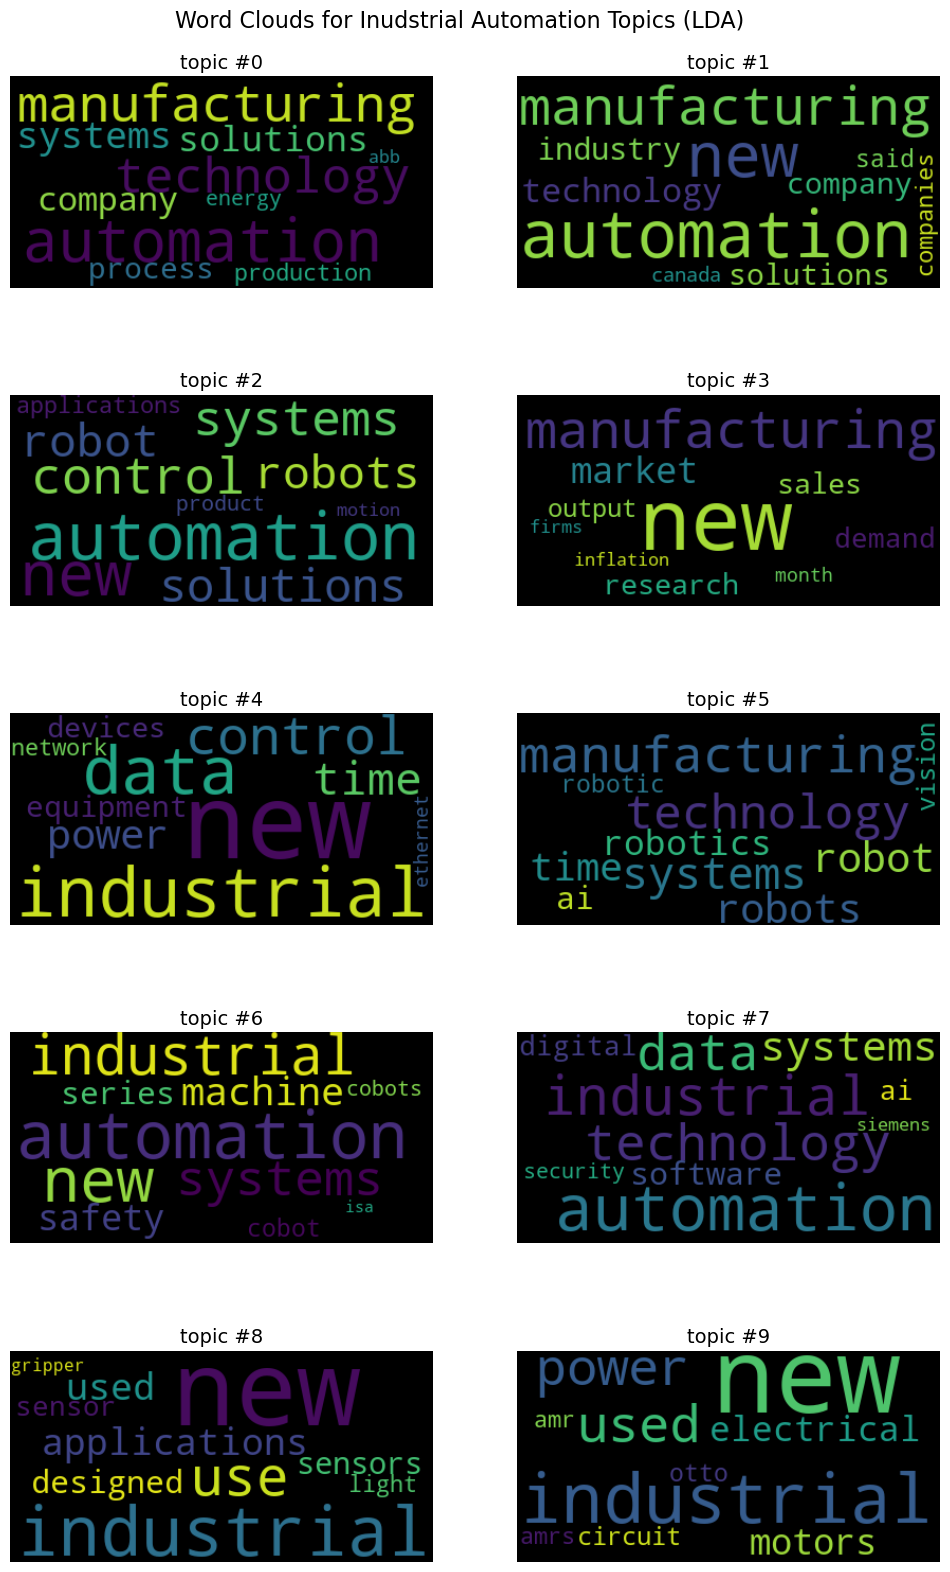

In [6]:
from wordcloud import WordCloud

vocab = TF_vectorizer.get_feature_names_out()
vocab_cnt = TF_vectors.toarray().sum(axis=0)
vocab_cnt_dict = dict(zip(vocab, vocab_cnt))

# retrieve topic matrix
topic_mat = []
words = TF_vectorizer.get_feature_names_out()
for topic_index, topic in enumerate(abs(lda_model.components_)):
    topic_mat.append([words[i] for i in topic.argsort()[:-10 - 1:-1]])

# generate topic word clouds
plt.figure(figsize=(12, 20))
plt.suptitle("Word Clouds for Inudstrial Automation Topics (LDA)", y=0.9, fontsize=16)
for i in range(10):
    words = topic_mat[i]
    freqs = [vocab_cnt_dict[w] for w in words]
    wordcloud = WordCloud().generate_from_frequencies(dict(zip(words, freqs)))
    
    plt.subplot(5, 2, i + 1)
    plt.axis("off")
    plt.title(f"topic #{i}", fontsize=14)
    plt.imshow(wordcloud, interpolation="bilinear")
    
plt.show()